In [1]:
import sys
sys.path.append('C:/Users/shjo/Bridge/JNUpack/SO/libs/')
import matplotlib as mpl
# mpl.use('agg')
from myPlot import  figmaster,myClrbr
import matplotlib.path as mpath
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from eofs.xarray import Eof
import numpy as np
import xarray as xr
import pickle
from myTrend import myfitting2d_sttcs,myfitting1d_sttcs
from myPlot import  figmaster,myClrbr, dta_colr
import matplotlib.pyplot as plt
from scipy.interpolate import griddata 
import warnings
warnings.filterwarnings('ignore')

pthMO='J:/MDLS_OBS_OHC/'
# pthrn='J:/Reanalysis/'

wpth='C:/Users/shjo/OneDrive/mySO/test/'

t_rng=[1993, 2020]
varnm='OHC700'
fig_bool=1

myName='Zonal mean '+varnm+' trend'
    

### Preparation ============================================================
wpth=wpth+varnm+'_'+str(t_rng[0])+'_'+str(t_rng[-1])+'/'
try :
    os.mkdir(wpth)
except:
    raise

# myRnly=[pthrn+i for i in os.listdir(pthrn) if i.endswith('.nc')]
myMDOB=[pthMO+i for i in os.listdir(pthMO) if i.endswith('.nc')]

myDATA=myMDOB

if t_rng[0]<1992:
    myDATA=[i for i in myDATA if not i.split('/')[-1].startswith('myECCO')]

plt.rcParams["font.family"] = 'Arial'

    


In [2]:
### Read myDATA =============================================================

print('!!! Open files !!!')
myEofs,myNm,myLat,myLon=[],[],[],[]
myPcs,myVar,myVar2=[],[],[]
lat_rng=[-75,-30]; lon_rng=[0,360]; time_rng=[str(t_rng[0])+'-01',str(t_rng[-1])+'-12']
for i in myDATA: 
    print('!!! Open: '+i+' !!!')
    tmp=xr.open_dataset(i)

    myDATA = tmp[varnm].loc[dict(lat=slice(lat_rng[0],lat_rng[-1]),lon=slice(lon_rng[0],lon_rng[-1]),\
        time=slice(time_rng[0],time_rng[-1]))]

    myDATA=myDATA.where(myDATA<10**30)
    
    
    time,latR,lonR=myDATA.time.values,myDATA.lat.values,myDATA.lon.values
    dta_nm=i.split('/')[-1][2:-3].split('_')[0]+' '+varnm+' eof '+\
        str(time[0])[:4]+' '+str(time[-1])[:4]

    OHC_1Y=myDATA.rolling(time=12,center=True).mean()[6:-5]

    ### EOFs ==================================================================
    NN=10
    
    solver=Eof(OHC_1Y)
    eofs = -solver.eofs(neofs=NN, eofscaling=0)
    pcs = -solver.pcs(npcs=NN,pcscaling=0)
    var_=solver.varianceFraction(NN)*100
    var=var_/np.sum(var_)*100
        
    myEofs.append(eofs); myNm.append(dta_nm); myLat.append(latR); myLon.append(lonR)
    myPcs.append(pcs); myVar.append(var_); myVar2.append(var) 
    
    ### Figure settings =============================================
    mySetting={
    'figsize': '',
    'mylabel': '',
    'Label_size':18,
    'title_loc':'right',
    'fontParams':'Arial',
    'wpth':wpth}
    
    fac=10**2
    sstTlim=[-.04*fac,.04*fac]
    F=figmaster(mySetting)
    CMAP,mylevel=myClrbr('myblc2',sstTlim,16)



!!! Open files !!!
!!! Open: J:/MDLS_OBS_OHC/myECCO_199201_201712_tsh.nc !!!
!!! Open: J:/MDLS_OBS_OHC/myEN4_198001_202012_tsh.nc !!!
!!! Open: J:/MDLS_OBS_OHC/myGECCO_198001_201812_ztshuv.nc !!!
!!! Open: J:/MDLS_OBS_OHC/myIAP_198001_201812_tshuv.nc !!!
!!! Open: J:/MDLS_OBS_OHC/myIAP_198001_201812_tshuv_real.nc !!!
!!! Open: J:/MDLS_OBS_OHC/myISHII_198001_201912_tsh.nc !!!


In [3]:
def myCrtpy_sph_pcolor(LAT,LON,DATA,CMAP,mylevel,myName,wpth):
    Spheric=ccrs.SouthPolarStereo(central_longitude=0.0,globe=None)
    PC = ccrs.PlateCarree(central_longitude=0.0,globe=None)
    fig, ax = plt.subplots(1, 1, figsize=(12.5,11),
                    subplot_kw={'projection': Spheric})
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cf.COASTLINE.with_scale("110m"), lw=1,zorder=110)
    ax.add_feature(cartopy.feature.LAND,color=[.75,.75,.75],zorder=100)
    ax.set_title(myName,loc='right',fontdict={'fontsize':32,'fontweight':'regular'})
    gl = ax.gridlines(crs=PC, draw_labels=True,y_inline=False,x_inline=False,
                    linewidth=.6, color='k', alpha=0.45, linestyle='-.')
    gl.rotate_labels=False
    gl.xlabels_top,gl.ylabels_right = True,True
    gl.xlabel_style = gl.ylabel_style = {"size" : 26}
    M=plt.contourf(LON,LAT,DATA,cmap=CMAP,levels=mylevel,transform=PC)
    # M=plt.pcolormesh(LON,LAT,DATA,cmap=CMAP,transform=PC,vmin=-3.5,vmax=3.5)
    ax.set_extent([LON[0][0], LON[0][-1], LAT[0][0], LAT[-1][0]], crs=PC)
    ax.tick_params(axis='both', which='major', labelsize=28)
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="5%", pad=1., axes_class=plt.Axes)
    fig.add_axes(ax_cb)
    cb=plt.colorbar(M,extend='both',pad=0.08,cax=ax_cb)
    cb.set_label(label='', weight='regular',fontsize=28)
    cb.ax.tick_params(labelsize=19)
    plt.tight_layout()
    if 1:
        # myName.replace(' ','_')
        plt.savefig(wpth)
    plt.show()
    
def plot_pcs(time,time2,pc,t_name,w_path,fig_bool=True):
    Label_size = 18
    fig, axs = plt.subplots(1,1,figsize=(10,3.7),constrained_layout = True,
                        dpi=200)
    f1 = axs.plot(time,pc, label='KINETIC_ENRG',color='k',linewidth=2,zorder=0)
    axs.set_title(t_name,loc='right',fontdict={'fontsize':20,'fontweight':'regular','fontstyle':'italic'})
    axs.tick_params(axis='both', labelsize=Label_size)
    axs.grid(axis='x',linestyle='-.')
    xtick_location = time[5::12*4]
    xtick_labels = time2[5::12*4]
    axs.set_xticks(ticks=xtick_location)
    axs.set_xticklabels(xtick_labels, rotation=0, fontsize=Label_size, alpha=1)
    axs.tick_params(axis='x', direction='in', length=6, pad=8, labelsize=Label_size, labelcolor='k', top=True,width=1.)
    axs.tick_params(axis='y', direction='in', length=6, pad=8, labelsize=Label_size-3, width=1., color='k')
    plt.tight_layout()
    if fig_bool:
        # plt.savefig(w_path+Dir_pth+'/ppt/'+save_name,
        #         facecolor='none',edgecolor='none',bbox_inches='tight',transparent=True)
        plt.savefig(w_path,bbox_inches='tight')
    plt.show()

In [4]:
for nm,lat_,lon_,eofs_,pcs_,var1_,var2_ in zip(myNm,myLat,myLon,myEofs,myPcs,myVar,myVar2):
    snm=wpth+nm.replace(' ','_')
    try :
        os.mkdir(snm)
    except:
        pass
    for eof,pc,var1,var2,N in zip(eofs_.values,pcs_.transpose(),var1_,var2_,range(1,len(eofs_)+1)):
        
        # print('max!!! : ',np.nanmax(eof))
        # print('min!!! : ',np.nanmin(eof))
        eof=
        
        eof[eof*fac<sstTlim[0] ]=sstTlim[0]
        eof[eof*fac>sstTlim[-1]]=sstTlim[-1]
        
        raise
        
        # print('max!!! : ',np.nanmax(eof))
        # print('min!!! : ',np.nanmin(eof))
        # raise
        
        TIME= [str(i)[0:7] for i in pcs_.time.values]
        TIME2=[str(i)[2:4] for i in pcs_.time.values]

        lonM,latM=np.meshgrid(lon_,lat_)
        
        t_nm=nm+f'\n{N:02d}'+' mode '+f'{var1:.1f}'+'% ('+f'{var2:.1f}'+'%)'
        s_nm=snm+'/'+nm.replace(' ','_')+'_'+f'{N:02d}'+'mode'

        myCrtpy_sph_pcolor(latM,lonM,eof*fac,CMAP,mylevel,t_nm,s_nm+'_eof')
        myCrtpy_sph_pcolor(latM,lonM,-eof*fac,CMAP,mylevel,t_nm,s_nm+'_eof_re')

        plot_pcs(TIME,TIME2,pc/fac,t_nm.replace('eof','pc'),s_nm+'_pc',fig_bool=True)
        plot_pcs(TIME,TIME2,-pc/fac,t_nm.replace('eof','pc'),s_nm+'_pc_re',fig_bool=True)
        

RuntimeError: No active exception to reraise

ValueError: not enough values to unpack (expected 2, got 1)

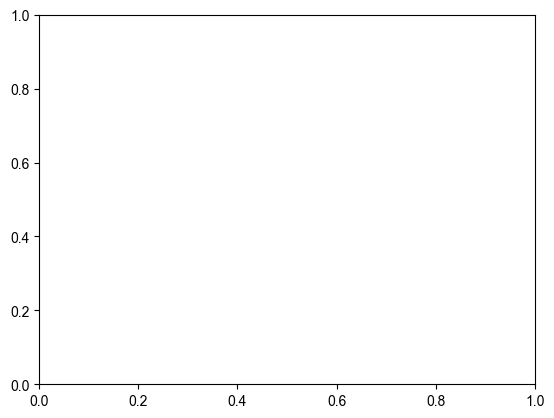

In [6]:
plt.pcolor(eof[2])

In [6]:
eof[0].shape

(720,)

In [ ]:
snm

In [7]:
import time

In [9]:
print(time.strftime('%Y.%m.%d - %H:%M:%S') )

2023.10.01 - 15:52:12


In [10]:
print(	time.strftime('%c'))

Sun Oct  1 15:52:37 2023


In [12]:
import os
import time
print(os.getcwd())
print(	time.strftime('%c'))

import sys
sys._getframe().f_code.co_filename 


c:\Users\shjo\Bridge\JNUpack\SO\main\EOFS


In [ ]:
# newfile.py
f = open("새파일.txt", 'w')
info=time.strftime('%c')+'\n'+os.getcwd()
f.write(info)
f.close()